# DSCI 512 Lab 4
<!-- rubric={mechanics:2} -->

## Discrete optimization (and in particular dynamic programming)

### IMPORTANT NOTES
1. This lab revolves around a single application area (resizing images), which is described below as the introduction to the lab.
3. This lab looks very long. Do not despair! It contains a lot of optional material and a lot of text to read. This makes it look much longer than it is.



##### Motivation
We often want to resize images (say, for different screen sizes/resolutions). A standard solution to making an image smaller would be to just discard some of the pixels. For example, if we want to make the image exactly half its original width and height, we can cut up the images into $2\times 2$ squares and just keep the upper-left pixel in each square. But what if you want to reduce the size of the image by 30%? Or, what if you want to change the aspect ratio of the image without distoring the image contents? Now things get more complicated. 

Here, we will explore a technique called _seam carving_. If you are interested, you can check out the 2007 paper by Shai Avidan and Ariel Shamir [_Seam Carving for Content-Aware Image Resizing_](http://www.cs.virginia.edu/~connelly/class/2013/cs6501/proj2/seamcarving.pdf). As the title of the paper suggests, this algorithm is about "content-aware" image resizing, which means that the pixels we add/remove are chosen based on the content itself. With seam carving, we can resize to any size, not just nice integer fractions like double or half.
 
Note: we will consider only the problem of making an image smaller. Seam carving can also be used to make an image larger but we skip that here in the interests of time. 

##### What's the basic idea?

Seam carving works by removing _seams_, one at a time. What is a seam? A _vertical seam_ is a connected path from the top to the bottom of the image, where the seam contains one pixel in each row. Similarly, a _horizontal seam_ is a connected path from the left to the right of the image, where the seam contains one pixel in each column. Below are some examples showing horizontal and vertical seams. 

Definition: a connected (vertical) path is a sequence of pixels, one per row, such that each pair of adjacent pixels are at most one column apart. And likewise for connected horizontal paths. See image: a vertical seam and a horizontal seam are shown in red, on top of the original image. 

![](http://www.ulfdittmer.com/imagej/imret-Im1.jpg)

Seam carving works by repeatedly removing (or adding) seams until the desired size is achieved. You do not need to worry about this part: you are  provided with the function `seam_carve` that takes in an image and a desired size, and calls `find_horizontal_seam` and `find_vertical_seam` until the desired size is reached.

##### How do we assess the quality of a seam? 
Seam carving works by defining an _energy function_, which is a proxy for how important each pixel is. You do not need to think about or understand this! Instead, we provide you with a function `energy` that takes in an image and returns an array of the same size containing the energy values. For those who are interested in what makes a good energy function, you can refer to the original paper (the basic idea is that when pixel intensities vary more rapidly, this indicates a more important part of the image, and thus higher energy). Next, assuming you have the energy in hand, a vertical or horizontal seam is simply the minimum energy path from top to bottom, or left to right, respectively. Note that for a path to be valid, it must be connected, meaning that all pixels in the path must be neighbours. 

In the three parts below, you will consider three different methods for finding the best seam out of all possible seams. You will discover that there are many ways of solving the same problem, and some are much better than others!

Below you are provided with the following functions:
  * `energy` 
  * `seam_carve` 
  * `remove_vertical_seam`
  * `remove_horizontal_seam`
  * `find_horizontal_seam`

You should understand what they do, but you do not need to understand how they work (this is the beauty of functions!). 

You are also provided with some test code that generates a random tiny image. We use a random tiny image because the recursive solution is so slow that you wouldn't be able to test the code on any real images.

The code below doesn't run (yet) because it's missing the `find_vertical_seam` function, which is what you will be working on.


In [4]:
# Inputs: image, a 3d numpy array of size NxMx3, where the 3rd dimension is for the colour channels.
# Outputs: an array of size NxM containing the energies
import numpy as np
from scipy.ndimage.filters import convolve
import skimage.io
import matplotlib.pyplot as plt
import sys
%matplotlib inline

# Computes the "energy" of an image, using the Laplacian of each colour channel and summing them up.
# Inputs: image, a 3d numpy array of size NxMx3
# Outputs: the energy image, a 2d numpy array of size NxM
def energy(image): 
    dy = np.array([-1, 0, 1])[:,None,None]
    dx = np.array([-1, 0, 1])[None,:,None]
    energy_img = convolve(image, dx)**2 + convolve(image, dy)**2
    return np.sum(energy_img, axis=2)

# Find the minimum-energy horizontal seam in an image. 
# Inputs: energy, a 2d numpy array containing the energy values. Size NxM.
# Outputs: a seam represented as a 1d array of length M, with all values between 0 and N-1. 
def find_horizontal_seam(energy):
    return find_vertical_seam(energy.T)

# Remove a vertical seam from an image:
# Inputs:  image, a 2d numpy array containing the pixel values. Size NxM.
#          seam, a 1d array (or list) containing the column index of each pixel in the seam. Length N, all values between 0 and M-1.
# Outputs: a new image that is smaller by 1 column. Size N by M-1.
def remove_vertical_seam(image, seam):
    height = image.shape[0]
    linear_inds = np.array(seam)+np.arange(image.shape[0])*image.shape[1]
    new_image = np.zeros((height,image.shape[1]-1,3), dtype="uint8")
    for c in range(3):
        temp = np.delete(image[:,:,c], linear_inds.astype(int)) 
        temp = np.reshape(temp, (height, image.shape[1]-1))
        new_image[:,:,c] = temp
    return new_image    

# Same as remove_vertical_seam above, but for a horizontal seam. The output image is size N-1 by M.
def remove_horizontal_seam(image, seam):
    return np.transpose(remove_vertical_seam(np.transpose(image,(1,0,2)), seam), (1,0,2))

# Resize an NxM image to a desired height and width. 
# Note: this function only makes images smaller. Enlarging an image is not implemented. 
# Inputs: image, a 3d numpy array of size NxMx3
#         desired_width, an integer giving the desired width
#         desired_height, an integer giving the desired height
# Outputs: the resized image, now of size N x desired_width x 3
def seam_carve(image, desired_height, desired_width):
    while image.shape[1] > desired_width:
        seam = find_vertical_seam(energy(image))
        assert len(seam) == image.shape[0], "the length of the seam must equal the height of the image"
        image = remove_vertical_seam(image, seam)
        sys.stdout.write('\rWidth is now %d' % image.shape[1])
    print()
    while image.shape[0] > desired_height:
        seam = find_horizontal_seam(energy(image))
        assert len(seam) == image.shape[1], "the length of the seam must equal the width of the image"
        image = remove_horizontal_seam(image, seam)
        sys.stdout.write('\rHeight is now %d' % image.shape[0])
    print()
    return image


(10, 10, 3)
Width is now 5
Height is now 5


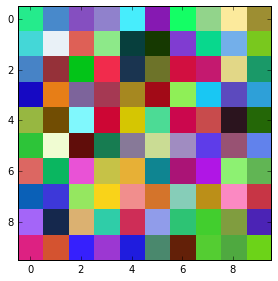

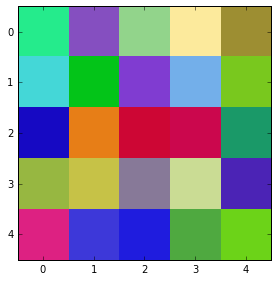

In [8]:
# img = skimage.io.imread('mandrill.jpg')
np.random.seed(1)
h = 10
w = 10
img = np.random.randint(0,255,(h,w,3)).astype("uint8")
print(img.shape)
plt.figure()
skimage.io.imshow(img)
e = energy(img)
# skimage.io.imshow(e)
# print(e)
img2 = seam_carve(img, h-5, w-5)
plt.figure()
skimage.io.imshow(img2)

### Part 1: recursive implementation
<!-- rubric={reasoning:3,mechanics:1} -->

What's the most obvious way of finding the best (lowest energy) seam? Well, just consider all possible paths, compute the total energy for each one, and take the minimum, right? We have provided a recursive implementation that follows this approach. The code is below. After running this cell to define `find_vertical_seam`, the test code about should now run without an error.

Questions for you:

2. What is the time complexity of `find_vertical_seam`, as a function of $N$ and $M$? You don't necessarily have to read through all the code carefully to answer this. You can just think about the process of enumerating all possible seams.
3. Using the test code above, what is the largest square image you can remove a vertical seam from within 10 seconds of compute time? (Note/reminder: you can use `%timeit` at the beginning of a line to time that line in ipython/Jupyter.)


In [1]:
def find_vertical_seam(energy):
    costs = dict()
    for i in range(energy.shape[1]):
        best_seam, best_cost = fvs(energy, [i], 0.0)
        costs[tuple(best_seam)] = best_cost
    return min(costs, key=costs.get) # the best out of the M best seams

def fvs(energy, seam, cost):
    row = len(seam)-1
    col = seam[-1]
    
    # if out of bounds on one of the two sides, return infinite energy
    if col < 0 or col >= energy.shape[1]:
        return seam, np.inf

    cost += energy[row,col]
    
    # regular base case: reached bottom of image
    if len(seam) == energy.shape[0]:
        return seam, cost

    return min((fvs(energy, seam+[col], cost),
                fvs(energy, seam+[col+1],cost),
                fvs(energy, seam+[col-1],cost)),key=lambda x:x[1])
    # above: could make syntax nicer if I was willing to tolerate some more inefficiency
    # by defining an energy function of seam and re-computing energy of the seam each time

_analysis goes here_

### (optional) Part 2: integer linear program
<!-- rubric={reasoning:1} -->

Maybe it's possible to do better than enumerating all possible seams. Here, we will try an approach that takes advantage of the _linearity_ of the problem. To pick a seam, let's define $NM$ binary variables $x_{ij}$, where $i$ represents the row and $j$ represents the column, so that we have one variable for each pixel. Note: a binary variable means a variable that can only take on the values 0 or 1.

Now, what do we know about a (vertical) seam? 

1. A vertical seam can only have one pixel per row.
2. If pixel $(i,j)$ is in the seam and $i<N$, then one of $(i+1,j-1)$, $(i+1,j)$, or $(i+1,j+1)$ must be in the seam. 

We can convert these into math using our $x_{ij}$ variables. The first one becomes

for all i: $\sum_{j=0}^{N-1}x_{ij}=1$. Make sure you understand this before moving on.

The second condition is a little trickier, but can be encoded mathematically using a similar idea (see the code if you are interested). 

Your task:

1. Write `find_vertical_seam` using the [PuLP Python package](http://pythonhosted.org/PuLP/). Most of the code is provided for you, but you need to fill some small parts of it of it in. Make sure your code gives the same result as your recursive implementation, for a small test image.
2. Compare the speed to your recursive implementation. What is the largest square image that this implementation can remove a vertical seam from in under 10 s?

(you are not asked about time complexity here because that is beyond the scope of this course)

In [ ]:
import pulp

def find_vertical_seam(energy):
    N, M = energy.shape
    
    # initialize the optimization problem, give it a name
    prob = pulp.LpProblem("Seam carving", pulp.LpMinimize)
    
    # create the x_ij variables
    x = pulp.LpVariable.dicts("pixels",(list(range(N)),list(range(M))),0,1,pulp.LpInteger)
    
    # The objective function is being built here. The objective is the sum of energies in the seam.
    objective_terms = list()
    for i in range(N):
        for j in range(M):
            objective_terms.append( ### FILL THIS IN ### )
    prob += pulp.lpSum(objective_terms) # adds up all the terms in the list
    
    # Constraint #1: one pixel per row
    ### FILL THIS IN ###

    # Constraint #2: connectivity of seam
    for i in range(N-1):
        for j in range(M): # below: this says: x(i,j) - x(i+1,j-1) - x(i+1,j) - x(i+1,j+1) <= 0
            prob += pulp.lpSum([x[i][j]]+[-x[i+1][k] for k in range(max(0,j-1),min(M,j+2))]) <= 0
    
    # Solve the problem
    prob.solve()
    
    # Build up the seam by collecting the pixels in the optimal seam
    # Note: you can access the values (0 or 1) of the variables with pulp.value(x[i][j])
    ### FILL THIS IN ###
    
    return seam

### Part 3: dynamic programming implementation.
<!-- rubric={code:8,reasoning:3,mechanics:1} -->

In part 1 we used a brute force approach of considering _all_ possible seams and taking the best one. In part 2 (optional) we took advantage of the linearity of the optimization problem. But, actually, this particular problem has more special structure beyond being linear. Loosely speaking, it is a bunch of sequential decisions, where the total objective is the sum of mini-objectives incurred by each decision (total energy = sum of individual seam pixel energies). This means we can use dynamic programming (DP). Hooray!

To use dynamic programming for seam carving, *create a table of size $N\times M$ (the same size as your energy image) that contains, at location $(i,j)$, the minimum energy required to get from the top of the image to that location.* At the first row, this is just the energy value. But for the next row, at location $(2,j)$, you might have arrived there from 3 possible places, namely $(1,j-1)$, $(1,j)$, or $(1,j+1$). You will need to take this into consideration. Proceed from here and then perform the backtracking (figuring out where you came from) to get your seam.


##### Your task
1. Implement `find_vertical_seam` using dynamic programming and add documentation about the function.
2. Using big-O notation, state the running time of `find_vertical_seam` as a function of the image height $N$ and width $M$.
4. Submit some resized images of your liking. Make sure to include both the original and resized image. You are provided with three images in this repository: mandrill, Halloween high-res ($2592\times 3888$), Halloween lower-res ($400\times 600$). These are shown at the very bottom of this document. 
3. (optional) If you did Part 2, compare the actual speed to your DP implementation from part 2.

Notes/hints/FAQ:

 - You may find the NumPy's `argmin` function useful. ([documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmin.html))
 - When testing this on actual images, use `img = skimage.io.imread(IMAGE_FILE_NAME)` to read in a NumPy array representation of the image. You can then pass this array into `seam_carve`. To look at an image after loading it in, you can use `skimage.io.imshow(img)`.  
 - the `fvs` function in Part 1 is part of the recursive implementation. Your solution to Part 3 should not use `fvs`.

In [ ]:
# code goes here

### (optional) Part 4: code vectorization
<!-- rubric={reasoning:1} -->

In part 3 you took things as far as they will go with better algorithms. But you still might not be satisfied with the performance. The next step is to optimize the implementation of the dynamic programming algorithm. A typical approach would be to ditch Python; while R might not be much faster (maybe it's slower?), other languages like C or perhaps Julia would speed things up. Another approach would be to use parallel computing, in which multiple threads of computation are performed at once (more on this in DSCI 525!). However, changing languages and parallelization are not always the only way. In part 3, you presumably implemented your forward pass with a nested `for` loop over the rows and columns of the image. However, certain languages (Python's NumPy, R, Matlab, etc.) do _vectorized_ operations much faster than loops. See below for an example:

In [4]:
N = 1000000
x = np.zeros(N)
def add_one_loop(x):
    for i in range(len(x)):
        x[i] += 1
%timeit add_one_loop(x)

1 loop, best of 3: 468 ms per loop


In [5]:
def add_one_vec(x):
    x = x + 1
%timeit add_one_vec(x)

100 loops, best of 3: 3.2 ms per loop


When I ran the two cells above, I found the vectorized implementation to be over 100 times faster. 

So, try rewriting your `find_vertical_seam` function with vectorized code. In particular, replace the loop over columns in the forward pass with a vectorized operation, using `np.min` on a 2-dimensional array to take the minimum across a particular dimension of the array all at once. Again, make sure you get the same answer as before to ensure you didn't introduce a bug. Then, compare the speed of your implementation to the non-vectorized implemetation. How much better is it?


*Dramatic Conclusion*

If you made it here and did all the parts, stop and reflect on how interesting this all is. You tried 4 approaches and (at least for me), each one is _significantly_ faster than the previous. Amazing! For the first three (recursive, LP, DP), the improvement was due to a better algorithm that takes advantage of the specific structure of the problem we are solving. The fourth case (vectorization) is the same algorithm but with a better implementation. This takes advantage of the details of how Python works. Don't forget, some problems can only be solved by enumerating all possibilities (approach 1). Those are the bad ones. Other problems are linear and can leverage LP but aren't DP problems (e.g. scheduling TAs for MDS labs given their availability, expertise, etc.). The big lesson is that you should understand the structure of your problem so that you can use the best possible algorithm. This might be the difference between your code taking 1 hour vs. 1 week.  

## Provided samples images for your enjoyment:

![](mandrill.jpg)
![](halloween-jack-o-lantern-bucket-with-witch-hat-and-candles.jpg)
![](halloween-jack-o-lantern-bucket-with-witch-hat-and-candles-400x600.jpg)